# Training

- Use this notebook after you've built your dataset to train the model.
- Training will create a model directory with:
    - `model_0000XXX.pth`: weights that are regularly saved during training
    - `config.yaml`: the model configuration used during the last training performed.
    - `training.log`: a log file that contains all the logs displayed in the notebook during training (useful if you close your notebook during a long training session).

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import logging

import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

env: CUDA_VISIBLE_DEVICES=0


## Check Dataset

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


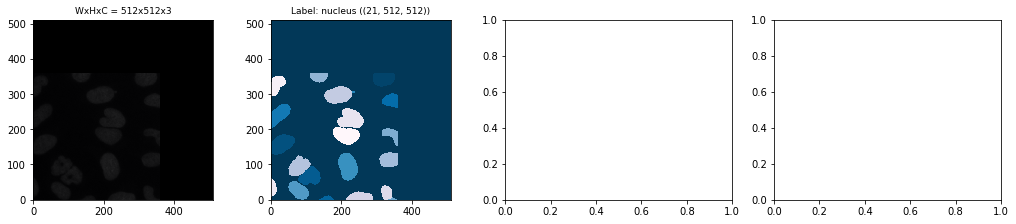

In [2]:
config['SOLVER']['IMS_PER_BATCH'] = 1
n_batch = 1

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=True)
some_data = [iter(data_loader).next() for _ in range(n_batch)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

for batch_image, batch_target, batch_idx in some_data:
    maskflow.viz.batch_display_top_masks(batch_image, batch_target, batch_idx, categories,
                                         basesize=14, limit=3, cmap="PuBu_r",
                                         pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                         pixel_std=config['INPUT']['PIXEL_STD'])

## Training

In [3]:
# Configure the training
config['DATA_DIR'] = str(data_dir)

config['MODEL']['DEVICE'] = "cuda"

config['DATALOADER']['NUM_WORKERS'] = 4
config['SOLVER']['IMS_PER_BATCH'] = 1

# Disable those settings if you want to use the training
# parameters from your config file.
custom_training = False
if custom_training:
    config['SOLVER']['MAX_ITER'] = 5000
    config['SOLVER']['BASE_LR'] = 0.0025
    config['SOLVER']['STEPS'] = [3500, 4500]
    config['SOLVER']['CHECKPOINT_PERIOD'] = 1000
    config['SOLVER']['WARMUP_ITERS'] = 50

#config['SOLVER']

In [4]:
# Setup training

# Use the last model in the model dir
# If False, create a new model from scratch.
# If `model_to_use` is set, we use this one instead.

builder_args = {}
builder_args['config'] = config
builder_args['model_dir'] = model_dir
builder_args['use_last_model'] = False
builder_args['model_to_use'] = None
builder_args['use_pretrained_weights'] = True

training_args = maskflow.training.build_model(**builder_args)

2018-11-06 15:51:41,738:INFO:root: Training model directory set: /home/hadim/.data/Neural_Network/Maskflow/Nucleus/Models/2018.11.06-15:51:41
2018-11-06 15:51:41,740:INFO:root: Building the model...
2018-11-06 15:51:44,469:INFO:root: Use pretrained weights from https://download.pytorch.org/models/maskrcnn/e2e_mask_rcnn_R_50_FPN_1x.pth
2018-11-06 15:51:44,798:INFO:maskrcnn_benchmark.utils.checkpoint: No checkpoint found. Initializing model from scratch
2018-11-06 15:51:44,800:INFO:maskrcnn_benchmark.utils.checkpoint: Saving checkpoint to /home/hadim/.data/Neural_Network/Maskflow/Nucleus/Models/2018.11.06-15:51:41/model_0000000.pth
2018-11-06 15:51:44,968:INFO:root: Create the data loader.


loading annotations into memory...


2018-11-06 15:51:45,406:INFO:root: Model ready to be trained.


Done (t=0.41s)
creating index...
index created!


In [5]:
# Run training

training_args['log_period'] = 20
training_args['log_losses_detailed'] = False
training_args['save_metrics'] = True

maskflow.training.do_train(**training_args)

2018-11-06 15:51:45,432:INFO:maskfow.training: Start training at iteration 0
2018-11-06 15:51:45,433:INFO:maskfow.training: Training will stop at 3000
2018-11-06 15:51:46,310:INFO:maskfow.training: Step: 0 | Loss: 11.405360 | ETA: 0:36:30 | LR: 0.000825 | Memory: 982 MB
2018-11-06 15:51:56,115:INFO:maskfow.training: Step: 20 | Loss: 2.646316 | ETA: 0:24:55 | LR: 0.001495 | Memory: 1562 MB
2018-11-06 15:52:06,961:INFO:maskfow.training: Step: 40 | Loss: 1.359906 | ETA: 0:25:43 | LR: 0.002165 | Memory: 1562 MB
2018-11-06 15:52:18,266:INFO:maskfow.training: Step: 60 | Loss: 0.555483 | ETA: 0:26:15 | LR: 0.002500 | Memory: 1562 MB
2018-11-06 15:52:29,502:INFO:maskfow.training: Step: 80 | Loss: 0.568460 | ETA: 0:26:23 | LR: 0.002500 | Memory: 1562 MB
2018-11-06 15:52:40,178:INFO:maskfow.training: Step: 100 | Loss: 0.591283 | ETA: 0:26:07 | LR: 0.002500 | Memory: 1562 MB
2018-11-06 15:52:50,808:INFO:maskfow.training: Step: 120 | Loss: 1.145266 | ETA: 0:25:52 | LR: 0.002500 | Memory: 1562 MB
2